In [6]:
import sys
sys.path.append("../Simulations/")

from units import *
import matplotlib.pyplot as plt
from tqdm import *
from scipy.integrate import nquad, quad
from scipy.special import erf, jn, jv, kn
import mpmath as mp
from skmonaco import mcimport, mcquad, mcmiser

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Single subhalo

In [7]:
def R0_VL(M0):
    """ Concentration-mass relation for Plummer profile from 1711.03554
    """
    return 1.2*kpc*(M0/(1e8*M_s))**0.5

def c200_SC(M200):
    """ Concentration-mass relation according to Sanchez-Conde&Prada14
    """
    x=np.log(M200*h) # Given in terms of M_s/h in S-C&P paper
    pars=[37.5153, -1.5093, 1.636e-2, 3.66e-4, -2.89237e-5, 5.32e-7][::-1]
    return np.polyval(pars, x)

def get_rs_rhos_NFW(M200):
    """ Get NFW scale radius and density
    """
    c200 = c200_SC(M200/M_s)
    r200 = (M200/(4/3.*np.pi*200*rho_c))**(1/3.)
    rho_s = M200/(4*np.pi*(r200/c200)**3*(np.log(1 + c200) - c200/(1 + c200)))
    r_s = r200/c200
    return r_s, rho_s

def get_rb_rhob_Burk(M200, p):
    """ Get Burkert scale radius and density
    """
    c200n = c200_SC(M200/M_s)
    c200b = c200n/p
    r200 = (M200/(4/3.*mp.pi*200*rho_c))**(1/3.)
    r_b = r200/c200b
    rho_b = M200/(r_b**3*mp.pi*(-2*mp.atan(c200b) + mp.log((1+c200b)**2*(1+c200b**2))))
    return r_b, rho_b

def F(x):
    """ Helper function for NFW deflection, from astro-ph/0102341
    """
    if x > 1:
        return mp.atan(mp.sqrt(x**2-1))/(mp.sqrt(x**2 - 1))
    elif x == 1:
        return 1
    elif x < 1:
        return mp.atanh(mp.sqrt(1-x**2))/(mp.sqrt(1-x**2))
    
def Ft(x, tau):
    """ Helper function for truncated NFW deflection
    """
    return tau**2/(tau**2 + 1)**2*((tau**2 + 1 + 2*(x**2 - 1))*F(x) + tau*mp.pi + (tau**2 - 1)*mp.log(tau) + mp.sqrt(tau**2 + x**2)*(-mp.pi + (tau**2 - 1)/tau*L(x, tau)))

def L(x, tau):
    """ Helper function for truncated NFW deflection
    """
    return mp.log(x/(mp.sqrt(tau**2 + x**2) + tau))

def Fb(x):
    """ Helper function for Burkert deflection
    """
    if x > 1:
        return mp.log(x/2.) + mp.pi/4.*(mp.sqrt(x**2 + 1) - 1) + mp.sqrt(x**2 + 1)/2*mp.acoth(mp.sqrt(x**2 + 1)) - 0.5*mp.sqrt(x**2 - 1)*mp.atan(mp.sqrt(x**2 - 1))
    elif x == 1:
        return -mp.log(2.) - mp.pi/4. + 1/(2*mp.sqrt(2))*(mp.pi + mp.log(3 + 2*mp.sqrt(2)))
    elif x < 1:
        return mp.log(x/2.) + mp.pi/4.*(mp.sqrt(x**2 + 1) - 1) + mp.sqrt(x**2 + 1)/2*mp.acoth(mp.sqrt(x**2 + 1)) + 0.5*mp.sqrt(1 - x**2)*mp.atanh(mp.sqrt(1 - x**2))

In [8]:
def MGauss(theta, M0, beta0):
    """ Enclosed mass in cylinder, Gaussian profile
    """
    return M0*(1-mp.exp(-theta**2/(2*beta0**2)))

def MPlumm(theta, M0, beta0):
    """ Enclosed mass in cylinder, Plummer profile
    """
    return M0*theta**2/(theta**2 + beta0**2)

def MNFW(r, M200):
    """ Enclosed mass in cylinder, NFW profile
    """
    r_s, rho_s = get_rs_rhos_NFW(M200)
    x = r/r_s
    M0 = 4*np.pi*r_s**3*rho_s
    phi_r = M0*(mp.log(x/2) + F(x))
    return phi_r/1e69

def MtNFW(r, M200, tau=15):
    """ Enclosed mass in cylinder, tNFW profile
    """
    r_s, rho_s = get_rs_rhos_NFW(M200)
    x = r/r_s
    M0 = 4*np.pi*r_s**3*rho_s
    phi_r = M0*Ft(x, tau)
    return phi_r/1e69

def MBurk(r, M200, p=0.7):
    """ Enclosed mass in cylinder, Burkert profile
    """
    r_b, rho_b = get_rb_rhob_Burk(M200, p)
    x = r/r_b
    M0 = 4*np.pi*r_b**3*rho_b
    phi_r = M0*Fb(x)
    return phi_r/1e69

In [9]:
def Cl_Gauss(R0, M0, Dl, v, l):
    beta0 = R0/Dl
    return (4*GN*M0*v/Dl**2)**2*np.pi/2.*np.exp(-l**2*beta0**2)

def Cl_Plummer(R0, M0, Dl, v, l):
    beta0 = R0/Dl
    return (4*GN*M0*v/Dl**2)**2*np.pi/2.*l**2*beta0**2*kn(1, l*beta0)**2

def Cl_Point(R0, M0, Dl, v, l):
    beta0 = R0/Dl
    return (4*GN*M0*v/Dl**2)**2*np.pi/2.

def Cl_NFW(M200, Dl, v, l):
    pref = 1e69**2*GN**2*v**2*8*mp.pi*l**2/Dl**4
    Mj = mp.quadosc(lambda theta: MNFW(theta*Dl, M200)*mp.j1(l*theta), [0, mp.inf], period=2*mp.pi/l)
    return pref*Mj**2

def Cl_tNFW(M200, Dl, v, l, tau=15):
    pref = 1e69**2*GN**2*v**2*8*mp.pi*l**2/Dl**4
    Mj = mp.quadosc(lambda theta: MtNFW(theta*Dl, M200, tau)*mp.j1(l*theta), [0, mp.inf], period=2*mp.pi/l)
    return pref*Mj**2

def Cl_Burk(M200, Dl, v, l, p=0.7):
    pref = 1e69**2*GN**2*v**2*8*mp.pi*l**2/Dl**4
    Mj = mp.quadosc(lambda theta: MBurk(theta*Dl, M200, p)*mp.j1(l*theta), [0, mp.inf], period=2*mp.pi/l)
    return pref*Mj**2

In [11]:
l_min = 1
l_max = 500
n_l = 50
l_ary = np.logspace(np.log10(l_min), np.log10(l_max), n_l)

In [12]:
M0 = 10**8*M_s
R0 = R0_VL(M0)
Dl = 10*kpc
v = 1e-3

In [13]:
Cl_NFW_ary = np.array([Cl_NFW(M0, Dl, v, l) for l in tqdm_notebook(l_ary)])/(1e-6*asctorad/Year)**2
Cl_tNFW_ary = np.array([Cl_tNFW(M0, Dl, v, l, tau=15) for l in tqdm_notebook(l_ary)])/(1e-6*asctorad/Year)**2
Cl_tNFW2_ary = np.array([Cl_tNFW(M0, Dl, v, l, tau=10) for l in tqdm_notebook(l_ary)])/(1e-6*asctorad/Year)**2
Cl_Burk_ary = np.array([Cl_Burk(M0, Dl, v, l) for l in tqdm_notebook(l_ary)])/(1e-6*asctorad/Year)**2

In [14]:
Cl_Plummer_ary = Cl_Plummer(R0, M0, Dl, v, l_ary)/(1e-6*asctorad/Year)**2;
Cl_Gauss_ary = Cl_Gauss(R0, M0, Dl, v, l_ary)/(1e-6*asctorad/Year)**2;
Cl_Point_ary = Cl_Point(R0, M0, Dl, v, l_ary)/(1e-6*asctorad/Year)**2;

/scratch/sm8383/anaconda3/envs/venv_smsharma/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/scratch/sm8383/anaconda3/envs/venv_smsharma/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/scratch/sm8383/anaconda3/envs/venv_smsharma/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/scratch/sm8383/anaconda3/envs/venv_smsharma/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


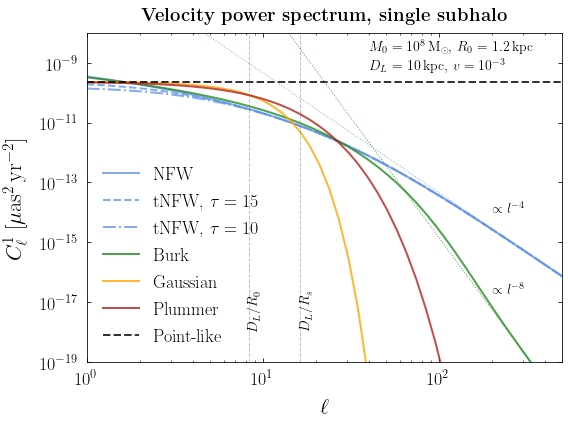

In [15]:
plt.figure(figsize=(8,6))
plt.plot(l_ary, Cl_NFW_ary, label="NFW", alpha=0.8, c='cornflowerblue')
plt.plot(l_ary, Cl_tNFW_ary, label="tNFW, $\\tau = 15$", alpha=0.8, ls='--', c='cornflowerblue')
plt.plot(l_ary, Cl_tNFW2_ary, label="tNFW, $\\tau = 10$", alpha=0.8, ls='-.', c='cornflowerblue')
plt.plot(l_ary, Cl_Burk_ary, label="Burk", alpha=0.8,c='forestgreen')
plt.plot(l_ary, Cl_Gauss_ary, label="Gaussian", alpha=0.8, c='orange')
plt.plot(l_ary, Cl_Plummer_ary, label="Plummer", alpha=0.8, color='firebrick')
plt.plot(l_ary, len(l_ary)*[Cl_Point_ary], label="Point-like", c='k', ls='--', alpha=0.8)

plt.axvline((1/(R0/Dl)), c='grey', lw=1, alpha=0.5, ls='--')
plt.text((1/(R0/Dl)),1e-17,'$D_L/R_0$',rotation=90, fontsize=14)

plt.axvline(1/(get_rs_rhos_NFW(M0)[0]/Dl), c='grey', lw=1, alpha=0.5, ls='--')
plt.text((1/(get_rs_rhos_NFW(M0)[0]/Dl)),1e-17,'$D_L/R_s$',rotation=90, fontsize=14)

n = 4
plt.plot(l_ary, (1/l_ary**n)*Cl_NFW_ary[-1]/(1/(l_ary**n)[-1]), lw=1, alpha=0.8, ls='dotted', c='cornflowerblue')

n = 8
l_base = 2000
fac = Cl_Burk(M0, Dl, v, l_base)/(1e-6*asctorad/Year)**2/(1/(l_base**n))
plt.plot(l_ary, (1/l_ary**n)*fac, lw=1, alpha=0.8, ls='dotted',c='forestgreen')

plt.xscale("log")
plt.yscale("log")
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell^{1}$ [$\mu$as$^2$\,yr$^{-2}$]")


plt.xlim(l_min, l_max)
plt.ylim(1e-19,1e-8)

plt.title('\\textbf{Velocity power spectrum, single subhalo}', fontsize=18.5, y=1.02)
plt.text(40, 2.3e-9,'$M_0 = 10^8\,$M$_\odot$, $R_0$ = ' + str(R0/kpc)[:3] + '\,kpc', fontsize=14)
plt.text(40, 5e-10,'$D_L$ = 10\,kpc, $v=10^{-3}$', fontsize=14)

plt.text(200, 1e-14,'$\propto l^{-4}$', fontsize=14)
plt.text(200, 2e-17,'$\propto l^{-8}$', fontsize=14)

plt.legend(frameon=False)

plt.tight_layout()
plt.savefig("single_sub.pdf")

# Populations

### Define some distributions

In [99]:
def rho_nfw(r):
    """Unnormalized NFW profile density"""
    r_s = 18*kpc
    return 1/((r/r_s)*(1+r/r_s)**2)

def rho_v(v):
    """Unnormalized SHM Maxwellian"""
    v0 = 220*Kmps
    if v > 550*Kmps: return 0
    return np.exp(-v**2/v0**2)

v0 = 220.*Kmps
vesc = 544.*Kmps
vsun = (11.*Kmps, 12.*Kmps + v0, 7.*Kmps)

Nesc = erf(vesc/v0) - 2/np.sqrt(np.pi)*vesc/v0*np.exp(-vesc**2/v0**2)

def fG(vvec):
    v = np.linalg.norm(vvec)
    return 1/(Nesc*np.pi**1.5*v0**3)*np.exp(-v**2/v0**2)*(v < vesc)

Rsun = 8*kpc
Rmin = 1*kpc
Rmax = 200*kpc
M_min = 1e6*M_s
M_max = 1e10*M_s

In [100]:
norm_rho_nfw = nquad(lambda l, theta: rho_nfw(np.sqrt(l**2 + Rsun**2 - 2*l*Rsun*np.cos(theta))), [[Rmin,Rmax],[0,2*np.pi]])[0]

In [101]:
def vproj(v, theta, phi, thetap, phip):
    v_vec = v*np.array([np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)])
    theta_hat = np.array([np.cos(thetap)*np.cos(phip), np.cos(thetap)*np.sin(phip), -np.sin(thetap)])
    phi_hat = [-np.sin(phip), np.cos(phip), 0]
    return np.sqrt(np.dot(v_vec,theta_hat)**2 + np.dot(v_vec,phi_hat)**2)

In [102]:
thetap, phip = np.pi/2., np.pi/2.
v_term, _ = nquad(lambda v, theta, phi: v**2*(vproj(v, theta, phi, thetap, phip))**2*np.sin(theta)*fG(v),
      [[0,950.*Kmps],[0,np.pi],[0,2*np.pi]])

# (w)CDM projections

In [298]:
def rho_m(ms, m=200*KeV):
    A0 = 2e8/M_s
    dNcdmdm = A0*(ms/M_s)**-1.9
    pref = (1 + mhm(m)/ms)**-1.3
    return pref*dNcdmdm

def mhm(m):
    return 1e10*(m/KeV)**-3.33*M_s/h

In [111]:
l_min = 1
l_max = 1000
l_ary = np.arange(0,1000)
l_ary_calc = np.logspace(np.log10(l_min), np.log10(l_max), 100)

In [112]:
DM_frac_fid = 0.2
dDM_frac_fid = 0.02

mWDM_fid = 3.3*KeV
dmWDM = 0.1*KeV

In [113]:
Rsun = 8*kpc
Rmin = 1*kpc
Rmax = 200*kpc
M_min = 1e5*M_s
M_max = 1e10*M_s

In [114]:
R0 = lambda M: 1.2*kpc*(M/(1e8*M_s))**0.5 # "Concentration"-mass relation from 1711.03554

In [115]:
norm_rho_m = quad(lambda m: dNwdmdm(m), M_min, M_max)[0]

In [116]:
m_avg = quad(lambda m: m*dNwdmdm(m), M_min, M_max)[0]/norm_rho_m

In [117]:
N_halos = DM_frac_fid*1/(m_avg/(1e12*M_s))

In [118]:
def f(x, ell, mWDM=1000.*KeV):
    l, theta, m = x[0], x[1], x[2]
    return Cl_Plummer(R0(m), m, l, 1, ell) / (1e-6*asctorad/Year)**2  * dNwdmdm(m,mWDM) * rho_nfw(np.sqrt(l**2 + Rsun**2 - 2*l*Rsun*np.cos(theta)))


In [119]:
conv_fid = [mcmiser(lambda x: f(x, ell, mWDM=mWDM_fid), npoints=5e4, xl=[Rmin,0,M_min], xu=[Rmax,2*np.pi,M_max], nprocs=1) for ell in tqdm_notebook(l_ary_calc)]
conv_mWDMp = [mcmiser(lambda x: f(x, ell, mWDM=mWDM_fid + dmWDM), npoints=5e4, xl=[Rmin,0,M_min], xu=[Rmax,2*np.pi,M_max], nprocs=1) for ell in tqdm_notebook(l_ary_calc)]
conv_mWDMm = [mcmiser(lambda x: f(x, ell, mWDM=mWDM_fid - dmWDM), npoints=5e4, xl=[Rmin,0,M_min], xu=[Rmax,2*np.pi,M_max], nprocs=1) for ell in tqdm_notebook(l_ary_calc)]


In [120]:
C_l_fid = N_halos*np.array(conv_fid)[:,0] / norm_rho_m * v_term / norm_rho_nfw

C_l_mWDMp = N_halos*np.array(conv_mWDMp)[:,0] / norm_rho_m * v_term / norm_rho_nfw
C_l_mWDMm = N_halos*np.array(conv_mWDMm)[:,0] / norm_rho_m * v_term / norm_rho_nfw

C_l_fracp = (DM_frac_fid + dDM_frac_fid)/DM_frac_fid*N_halos*np.array(conv_fid)[:,0] / norm_rho_m * v_term / norm_rho_nfw
C_l_fracm = (DM_frac_fid - dDM_frac_fid)/DM_frac_fid*N_halos*np.array(conv_fid)[:,0] / norm_rho_m * v_term / norm_rho_nfw

In [130]:
from scipy.interpolate import interp1d

C_l_fid = np.interp(l_ary, l_ary_calc, C_l_fid)

C_l_mWDMp = np.interp(l_ary, l_ary_calc, C_l_mWDMp)
C_l_mWDMm = np.interp(l_ary, l_ary_calc, C_l_mWDMm)

C_l_fracp = np.interp(l_ary, l_ary_calc, C_l_fracp)
C_l_fracm = np.interp(l_ary, l_ary_calc, C_l_fracm)

In [131]:
sigma_mu = 1 # in muas/yr
N0 = 0.01e9*4*np.pi

N_l = np.ones_like(l_ary)*sigma_mu**2/N0

## Fisher

In [132]:
npar_vary = 2

In [136]:
lmax = l_max
nbins = 1

In [137]:
cl_fid_arr = np.zeros([int((lmax)/NLB), nbins, nbins])

In [139]:
cl_fid_arr[:, 0, 0] = C_l_fid

In [194]:
dcl_arr = []
dcl_arr.append((C_l_fracp-C_l_fracm)/(2*dDM_frac_fid))
dcl_arr.append((C_l_mWDMp-C_l_mWDMm)/(2*dmWDM))

In [195]:
dcl_arr = np.array(dcl_arr)

In [196]:
fsky = 0.5

In [260]:
fishermat = []

sigma_mus =[1, 10]
N0s = [0.1e9*4*np.pi, 0.001e9*4*np.pi]

for sigma_mu, N0 in zip(sigma_mus, N0s):
    
    fshr_l=np.zeros([npar_vary,npar_vary,lmax+1])
    fshr_cls=np.zeros([npar_vary,npar_vary])

    cl_noise_arr = np.zeros([int((lmax)), nbins, nbins])
#     sigma_mu = 10 # in muas/yr
#     N0 = 0.1e9*4*np.pi
    cl_noise_arr[:, 0, 0] = np.ones_like(l_ary)*sigma_mu**2/N0



    for lb in np.arange((lmax)) :
        l=lb
        if l==0 :
            continue
        ell=float(l)
        cl_fid=cl_fid_arr[int(lb)]
        cl_noise=cl_noise_arr[int(lb)]
        icl=np.linalg.inv(cl_fid+cl_noise)
        for i in np.arange(npar_vary) : ##
            dcl1=dcl_arr[i,int(lb)] ##
            for j in np.arange(npar_vary-i)+i :
                dcl2=dcl_arr[j,int(lb)]
                fshr_l[i,j,int(l)]=fsky*(ell+0.5)*np.trace(np.dot(dcl1,np.dot(icl,np.dot(dcl2,icl))))
                if i!=j :
                    fshr_l[j,i,int(l)]=fshr_l[i,j,int(l)]

    

    fshr_cls[:,:]=np.sum(fshr_l,axis=2)
    fishermat.append(fshr_cls)

In [261]:
# fshr = fshr_cls
# covar=np.linalg.inv(fshr)

# for i in np.arange(npar_vary):
#     sigma_m=np.sqrt(covar[i,i])
#     print(sigma_m)

In [262]:
from matplotlib.patches import Ellipse

In [263]:
fc = ['None','None']
lw = [1,1]
lc = ['forestgreen','cornflowerblue']

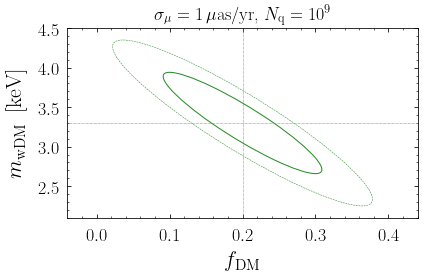

In [287]:
f, ax = plt.subplots() 

sig0_max=0
sig1_max=0

for i in range(len(fishermat)):
    covar=np.linalg.inv(fishermat[i])
#     covar=np.zeros([2,2])
#     covar[0,0]=covar_full[i1,i1]
#     covar[0,1]=covar_full[i1,i2]
#     covar[1,0]=covar_full[i2,i1]
#     covar[1,1]=covar_full[i2,i2]


    sig0=np.sqrt(covar[0,0])
    sig1=np.sqrt(covar[1,1])

    if sig0>=sig0_max :
        sig0_max=sig0
    if sig1>=sig1_max :
        sig1_max=sig1

    w,v=np.linalg.eigh(covar)
    angle=180*np.arctan2(v[1,0],v[0,0])/np.pi
    a_1s=np.sqrt(2.3*w[0])
    b_1s=np.sqrt(2.3*w[1])
    a_2s=np.sqrt(6.17*w[0])
    b_2s=np.sqrt(6.17*w[1])

    centre=np.array([DM_frac_fid, mWDM_fid])


    e_1s=Ellipse(xy=centre,width=2*a_1s,height=2*b_1s,angle=angle,
                facecolor=fc[i],linewidth=lw[i],edgecolor=lc[i])
    e_2s=Ellipse(xy=centre,width=2*a_2s,height=2*b_2s,angle=angle,linestyle="dashed",
                facecolor=fc[i],linewidth=lw[i]/2.,edgecolor=lc[i])

    ax.add_artist(e_2s)
    ax.add_artist(e_1s)

    nmult = 12
    ax.set_xlim(DM_frac_fid - nmult*dDM_frac_fid, DM_frac_fid + nmult*dDM_frac_fid)
    ax.set_ylim(mWDM_fid - nmult*dmWDM, mWDM_fid + nmult*dmWDM)

    # ax.set_xlim([params[i1].val-fact_axis*sig0_max,
    #              params[i1].val+fact_axis*sig0_max])
    # ax.set_ylim([params[i2].val-fact_axis*sig1_max,
    #              params[i2].val+fact_axis*sig1_max])
    ax.set_xlabel('$f_\mathrm{DM}$')
    ax.set_ylabel('$m_\mathrm{wDM}\,$ [keV]')

    ax.axvline(DM_frac_fid, ls='dotted', c='grey', lw=0.5)
    ax.axhline(mWDM_fid, ls='dotted', c='grey', lw=0.5)

plt.title("$\sigma_\mu = 1\,\mu$as/yr, $N_\mathrm{q}=10^9$")
plt.tight_layout()
plt.savefig("wDM.pdf")

In [292]:
m_ary

array([1.11609150e+67, 1.62541816e+67, 2.36717526e+67, 3.44743208e+67,
       5.02066247e+67, 7.31183414e+67, 1.06485785e+68, 1.55080411e+68,
       2.25851121e+68, 3.28917936e+68, 4.79019135e+68, 6.97618787e+68,
       1.01597606e+69, 1.47961519e+69, 2.15483532e+69, 3.13819114e+69,
       4.57029989e+69, 6.65594929e+69, 9.69338162e+69, 1.41169416e+70,
       2.05591864e+70, 2.99413397e+70, 4.36050245e+70, 6.35041111e+70,
       9.24841155e+70, 1.34689101e+71, 1.96154267e+71, 2.85668968e+71,
       4.16033567e+71, 6.05889851e+71, 8.82386763e+71, 1.28506262e+72,
       1.87149899e+72, 2.72555470e+72, 3.96935744e+72, 5.78076766e+72,
       8.41881219e+72, 1.22607243e+73, 1.78558872e+73, 2.60043941e+73,
       3.78714598e+73, 5.51540428e+73, 8.03235062e+73, 1.16979016e+74,
       1.70362212e+74, 2.48106748e+74, 3.61329885e+74, 5.26222227e+74,
       7.66362939e+74, 1.11609150e+75])

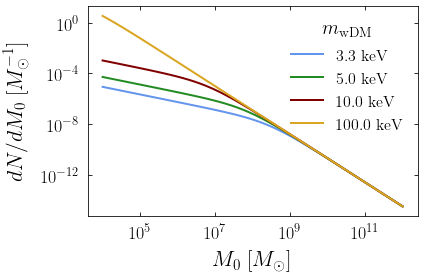

In [316]:
for mwdm in [3.3*KeV, 5*KeV, 10*KeV, 100*KeV]:
    m_ary = np.logspace(4,12)*M_s
    dNwdmdm_ary = np.array([rho_m(m, mwdm) for m in m_ary])
    plt.plot(m_ary/M_s, dNwdmdm_ary*M_s, label=str(mwdm/KeV) + " keV")
    plt.xscale("log")
    plt.yscale("log")
plt.legend()
plt.xlabel("$M_{0}$ $[M_\odot]$")
plt.ylabel("$dN/dM_{0}$ $[M_\odot^{-1}]$")
legend = plt.legend(title="$m_\mathrm{wDM}$", ncol=1, fontsize=16, frameon=False)
plt.setp(legend.get_title(),fontsize=20)
plt.tight_layout()
plt.savefig("dNdm_param.pdf")

## wDM

In [ ]:
def rho_m(ms, m=200*KeV):
    A0 = 2e8/M_s
    dNcdmdm = A0*(ms/M_s)**-1.9
    pref = (1 + mhm(m)/ms)**-1.3
    return pref*dNcdmdm

def mhm(m):
    return 1e10*(m/KeV)**-3.33*M_s/h

In [297]:
def dNwdmdm(ms, m):
    A0 = 2e8/M_s
    dNcdmdm = A0*(ms/M_s)**-1.9
    pref = (1 + mhm(m)/ms)**-1.3
    return pref*dNcdmdm

def mhm(m):
    return 1e10*(m/KeV)**-3.33*M_s/h

In [575]:
# for mwdm in [3.3*KeV, 5*KeV, 10*KeV, 100*KeV]:
#     m_ary = np.logspace(4,12)*M_s
#     dNwdmdm_ary = np.array([dNwdmdm(m, mwdm) for m in m_ary])
#     plt.plot(m_ary/M_s, dNwdmdm_ary*M_s, label=mwdm/KeV)
#     plt.xscale("log")
#     plt.yscale("log")
# plt.legend()
# plt.xlabel("$M_{vir}$ $[M_\odot]$")
# plt.ylabel("$dN/dM_{vir}$ $[M_\odot^{-1}]$")

In [576]:
DM_frac_fid = 0.2
dDM_frac_fid = 0.02

mWDM_fid = 3.3*KeV
dmWDM = 0.1*KeV



In [577]:
norm2 = quad(lambda m: dNwdmdm(m, mWDM_fid), M_min, M_max)[0]
m_avg = quad(lambda m: m*dNwdmdm(m, mWDM_fid), M_min, M_max)[0]/norm2
N_halos = DM_frac_fid*1/(m_avg/(1e12*M_s))
print(N_halos)

432.53314961619554


In [578]:
l_min = 20
l_max = 100
l_ary = np.arange(l_min, l_max)

In [583]:
def rho_m(m, alpha=1.9):
    return (m/M_s)**-alpha

rho_m(1e8*M_s)

6.309573444801943e-16

In [580]:
conv = [nquad(lambda l, theta, m: Cl_Plummer(R0(m), m, l, 1, l_lo) / (1e-6*asctorad/Year)**2  * dNwdmdm(m, mWDM_fid) * rho_nfw(np.sqrt(l**2 + Rsun**2 - 2*l*Rsun*np.cos(theta))), [[Rmin,Rmax],[0,2*np.pi],[M_min,M_max]]) for l_lo in tqdm_notebook(range(l_min, l_max))]


In [1]:
# conv = [nquad(lambda l, theta, m: Cl_Plummer(R0(m), m, l, 1, l_lo) / (1e-6*asctorad/Year)**2 * rho_nfw(np.sqrt(l**2 + Rsun**2 - 2*l*Rsun*np.cos(theta))), [[Rmin,Rmax],[0,2*np.pi],[M_min,M_max]], opts={'epsrel':0.5, 'epsabs':0}) for l_lo in tqdm_notebook(range(l_min, l_max))]